```
Topic:        Project 2
Subject:      Projecting Premier League Players' Salaries with Quantitative Statistics
Date:         07/17/2020
Name:         David Weon

Notebook has been cleaned using nbextension 'Code prettify'
```

# Linear Regression on Premier League Players' Salaries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import preprocessing
from sklearn.model_selection import KFold

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Data Check and Clean

In [2]:
premleague_df = pd.read_csv('premleague_salary_stats_edited.csv', index_col = 'index')

In [3]:
def editsomemore(dataframe):
    '''
    input: dataframe
    output: dataframe with salary data cleaned and unneeded columns dropped
    '''
    #player salary data clean
    dataframe = dataframe[dataframe['Annual_Salary(GBP)'].notna()]
    dataframe['Annual_Salary(Mil_GBP)'] = dataframe['Annual_Salary(GBP)']/1000000
    
    #dropping unneded column
    dataframe.drop(columns=['Unnamed: 0', 'Annual_Salary(GBP)', 'Pos'], inplace=True)
    
    return dataframe

In [4]:
premleague = editsomemore(premleague_df)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [5]:
#creating per90 values
premleague['TotPassAtt/90'] = premleague['TotPassAtt'] / premleague['90s']
premleague['KP/90'] = premleague['KP'] / premleague['90s']
premleague['Prog/90'] = premleague['Prog'] / premleague['90s']
premleague['Touches/90'] = premleague['Touches'] / premleague['90s']
premleague['DribPl/90'] = premleague['DribPl'] / premleague['90s']
premleague['Rec/90'] = premleague['Rec'] / premleague['90s']

#filling NaN with 0 for per90 values
premleague = premleague.fillna(0)
#checking or NaN, inf, -inf
premleague = premleague[~premleague.isin([np.nan, np.inf, -np.inf]).any(1)]
#dropping original columns
premleague.drop(columns=['TotPassAtt', 'KP', 'Prog', 'Touches', 'DribPl', 'Rec', '90s'], inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [6]:
premleague.info()

<class 'pandas.core.frame.DataFrame'>
Index: 383 entries, aaron cresswell to yves bissouma
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     383 non-null    float64
 1   MP                      383 non-null    float64
 2   Starts                  383 non-null    float64
 3   CrdY                    383 non-null    float64
 4   P90Gls                  383 non-null    float64
 5   P90Ast                  383 non-null    float64
 6   Sh/90                   383 non-null    float64
 7   SoT/90                  383 non-null    float64
 8   Annual_Salary(Mil_GBP)  383 non-null    float64
 9   TotPassAtt/90           383 non-null    float64
 10  KP/90                   383 non-null    float64
 11  Prog/90                 383 non-null    float64
 12  Touches/90              383 non-null    float64
 13  DribPl/90               383 non-null    float64
 14  Rec/90                 

In [7]:
premleague.describe()

,Age,MP,Starts,CrdY,P90Gls,P90Ast,Sh/90,SoT/90,Annual_Salary(Mil_GBP),TotPassAtt/90,KP/90,Prog/90,Touches/90,DribPl/90,Rec/90
count,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000
mean,26.412533,22.493473,18.067885,2.684073,0.120183,0.142324,1.202454,0.412480,3.499022,46.478392,0.884697,4.083642,57.499856,0.933144,37.231807
std,4.070974,11.192711,11.887808,2.688337,0.176677,0.925784,1.151765,0.532906,2.615178,17.894211,1.045775,2.974331,18.262878,0.912065,15.637768
min,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,13.000000,8.000000,1.000000,0.000000,0.000000,0.405000,0.065000,1.820000,32.051960,0.222222,2.097002,44.764142,0.221405,26.895738
50%,26.000000,24.000000,18.000000,2.000000,0.050000,0.050000,0.810000,0.230000,2.808000,45.259740,0.655022,3.774194,56.649077,0.738007,34.936170
75%,29.000000,32.000000,29.000000,4.000000,0.170000,0.140000,1.830000,0.645000,4.680000,57.772624,1.344719,5.700404,68.995098,1.444444,46.027033
max,54.000000,38.000000,38.000000,14.000000,1.450000,18.000000,7.500000,4.620000,18.200000,110.000000,10.000000,30.000000,140.000000,6.300000,88.500000


# Visualizing Data

In [10]:
premleague.corr()

,Age,MP,Starts,CrdY,P90Gls,P90Ast,Sh/90,SoT/90,Annual_Salary(Mil_GBP),TotPassAtt/90,KP/90,Prog/90,Touches/90,DribPl/90,Rec/90
Age,1.000000,-0.071238,-0.003718,-0.020112,-0.060305,-0.054940,-0.119387,-0.110581,0.190200,-0.032050,-0.064582,-0.062571,-0.093300,-0.323451,-0.144705
MP,-0.071238,1.000000,0.913482,0.501441,0.245902,-0.082447,0.107395,0.061721,0.244572,-0.018900,0.025637,-0.011342,-0.023780,0.160285,0.023369
Starts,-0.003718,0.913482,1.000000,0.538757,0.116856,-0.078511,-0.081749,-0.090564,0.223489,0.058182,-0.063104,0.010532,0.023303,-0.017432,-0.012580
CrdY,-0.020112,0.501441,0.538757,1.000000,0.013239,-0.055735,-0.070446,-0.104081,0.046150,0.166758,-0.036743,0.162300,0.178794,0.001507,0.104663
P90Gls,-0.060305,0.245902,0.116856,0.013239,1.000000,-0.000153,0.533001,0.554688,0.320650,-0.228418,0.194830,-0.070087,-0.180849,0.360497,0.017428
P90Ast,-0.054940,-0.082447,-0.078511,-0.055735,-0.000153,1.000000,0.012369,-0.000416,-0.003750,-0.022170,0.496742,0.125084,0.011519,-0.011564,0.060778
Sh/90,-0.119387,0.107395,-0.081749,-0.070446,0.533001,0.012369,1.000000,0.800265,0.245188,-0.233543,0.375823,0.040483,-0.116613,0.499797,0.117228
SoT/90,-0.110581,0.061721,-0.090564,-0.104081,0.554688,-0.000416,0.800265,1.000000,0.251521,-0.259971,0.257998,0.082598,-0.170058,0.436314,0.058999
Annual_Salary(Mil_GBP),0.190200,0.244572,0.223489,0.046150,0.320650,-0.003750,0.245188,0.251521,1.000000,0.207487,0.193706,0.200619,0.193891,0.153884,0.334751
TotPassAtt/90,-0.032050,-0.018900,0.058182,0.166758,-0.228418,-0.022170,-0.233543,-0.259971,0.207487,1.000000,0.186995,0.640450,0.976415,-0.037386,0.879651


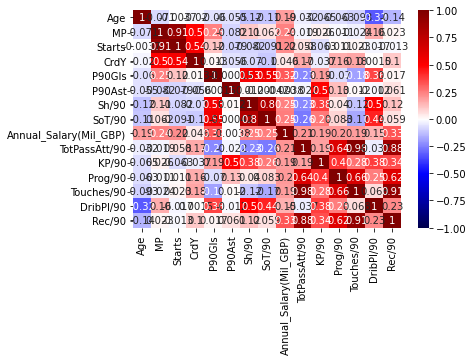

In [11]:
sns.heatmap(premleague.corr(), cmap='seismic', annot=True, vmin=-1, vmax=1);

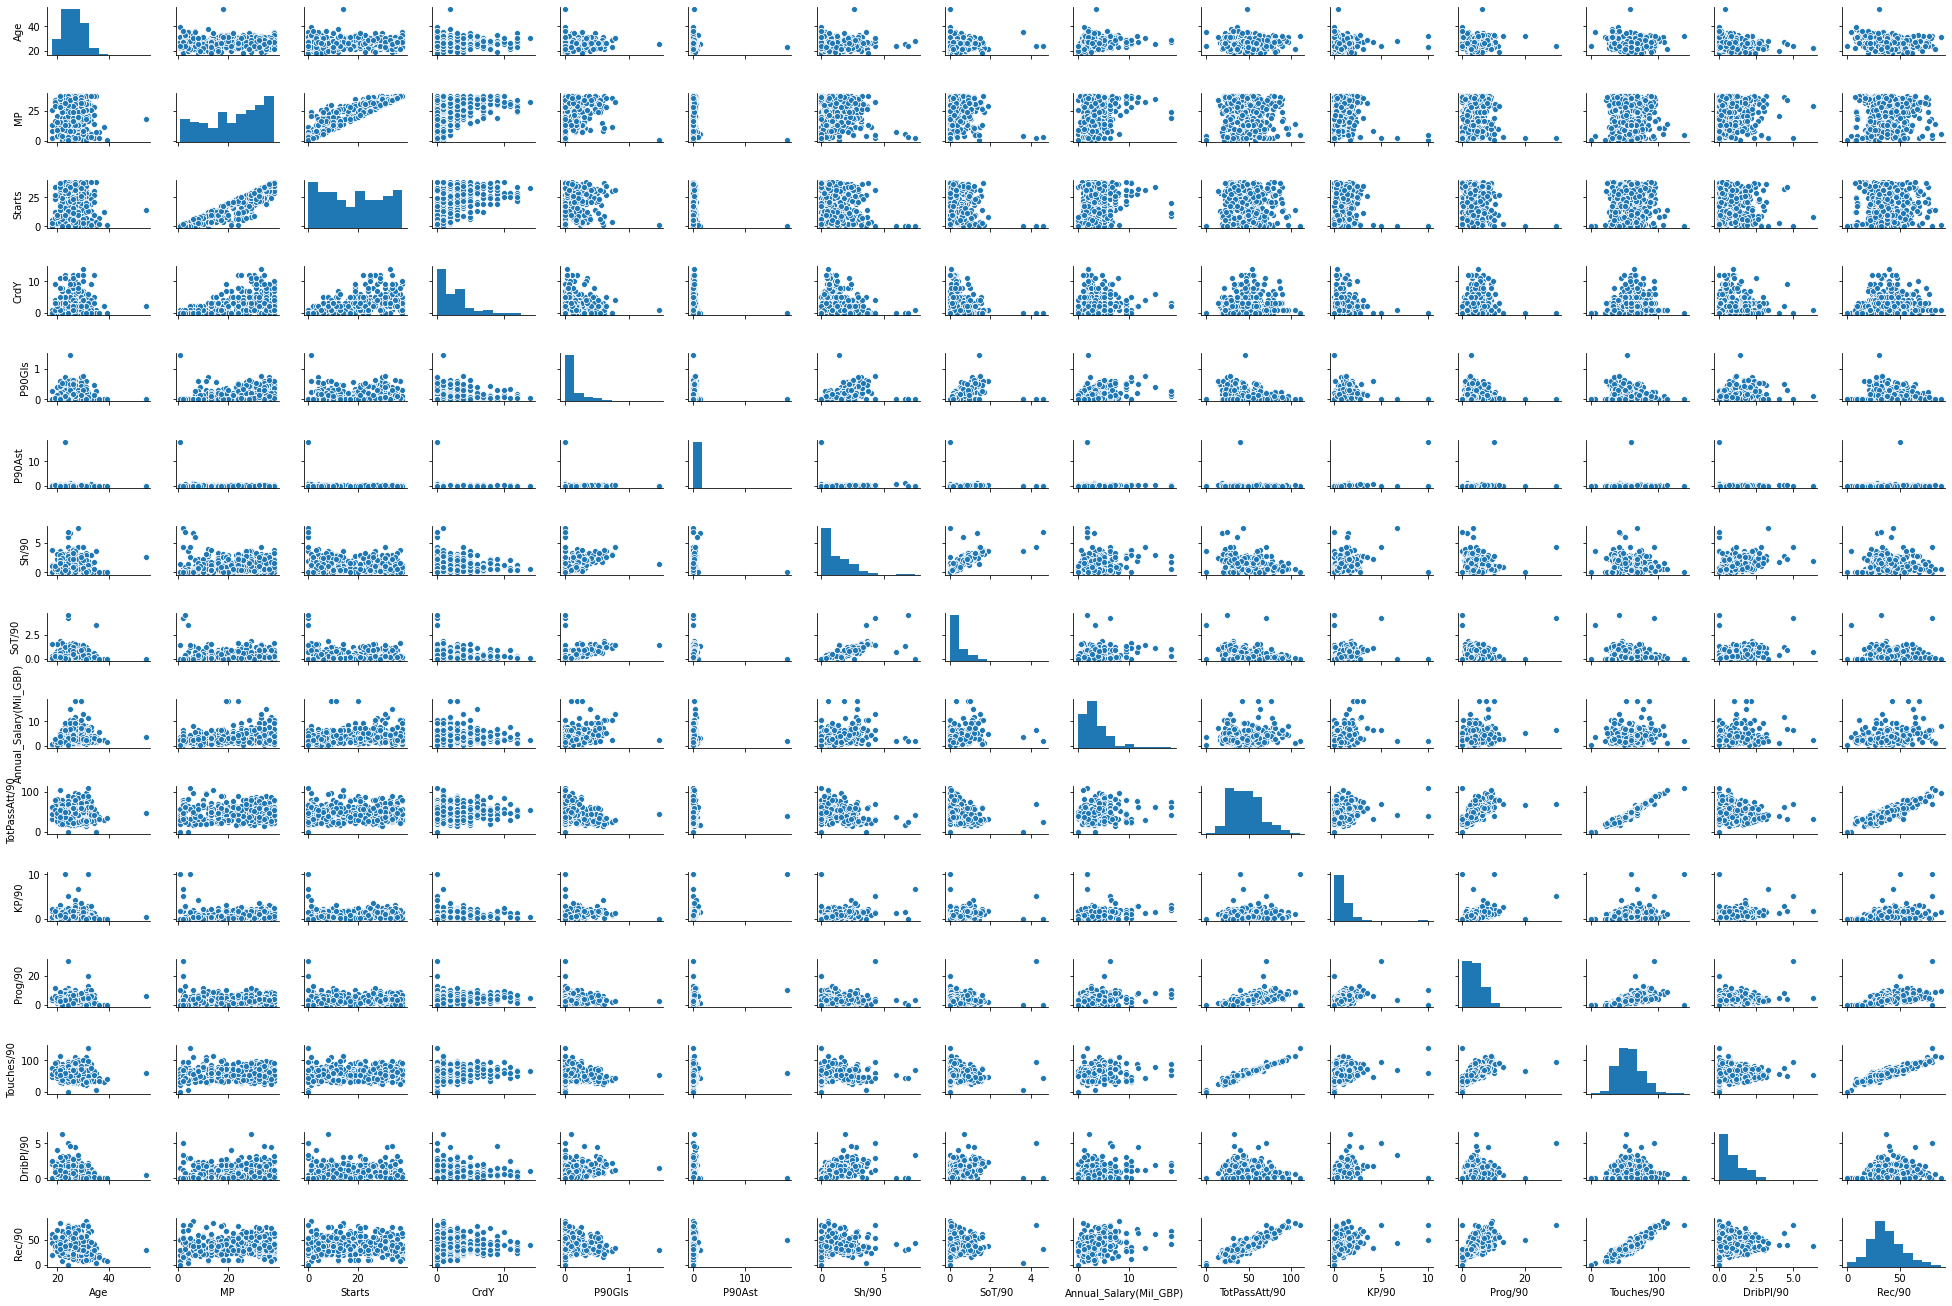

In [12]:
sns.pairplot(premleague, height=1.2, aspect=1.5);

# Modeling

## Baseline Model: Cross-Validation

In [8]:
X, y = premleague.drop('Annual_Salary(Mil_GBP)',axis=1), premleague['Annual_Salary(Mil_GBP)']

In [9]:
def crossval(X, y):
    '''
    input: X(dataframe) of features, y(series) of target
    output: simple mean cross-validation, ridge mean cross-validation
    '''
    X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing

    #this helps with the way kf will generate indices below
    X, y = np.array(X), np.array(y)
     
    #run the CV
    kf = KFold(n_splits=5, shuffle=True, random_state = 71)
    cv_lm_r2s, cv_lm_reg_r2s = [], [] #collect the validation results for both models

    for train_ind, val_ind in kf.split(X,y):
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 

        #simple linear regression
        lm = LinearRegression()
        lm_reg = Ridge(alpha=0.17)

        lm.fit(X_train, y_train)
        cv_lm_r2s.append(lm.score(X_val, y_val))
    
        #ridge with feature scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
    
        lm_reg.fit(X_train_scaled, y_train)
        cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))

    print('Simple regression scores: ', cv_lm_r2s)
    print('Ridge scores: ', cv_lm_reg_r2s, '\n')

    print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
    print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')

In [10]:
crossval(X, y)

Simple regression scores:  [0.38610055226648565, 0.38828817743716515, 0.23500762550359644, 0.005467543230642913, -1.2188427981161514]
Ridge scores:  [0.3854706111728049, 0.392937422301635, 0.23299219379232827, 0.0048585280033572875, -1.2491677338814937] 

Simple mean cv r^2: -0.041 +- 0.605
Ridge mean cv r^2: -0.047 +- 0.618


## Model Tuning

### Dropping Features

In [11]:
#dropping overlapping and unneeded features
X2, y2 = premleague.drop(['Annual_Salary(Mil_GBP)', 'CrdY', 'P90Ast'],
                         axis=1), premleague['Annual_Salary(Mil_GBP)']

In [12]:
crossval(X2, y2)

Simple regression scores:  [0.4098219602214167, 0.41838309983341304, 0.23575431445670159, 0.00022318116144770528, 0.3100829767861163]
Ridge scores:  [0.4109051922251944, 0.42302864064160894, 0.23365874848010382, 0.0003433165996691301, 0.3123365236367096] 

Simple mean cv r^2: 0.275 +- 0.153
Ridge mean cv r^2: 0.276 +- 0.154


In [13]:
#drop highly correlated features - (TotPassAtt/90, Touches/90)
X3, y3 = premleague.drop([
    'Annual_Salary(Mil_GBP)', 'CrdY', 'P90Ast', 'TotPassAtt/90', 'Touches/90'
],
                         axis=1), premleague['Annual_Salary(Mil_GBP)']

In [14]:
crossval(X3, y3)

#resulted in lower r^2 values

Simple regression scores:  [0.3815642868488319, 0.46006393768211873, 0.15499382335043665, -0.11017473023089819, 0.332591390352176]
Ridge scores:  [0.3813678189970259, 0.46029929580277396, 0.1551872444887361, -0.10906584482389081, 0.3325361108876822] 

Simple mean cv r^2: 0.244 +- 0.203
Ridge mean cv r^2: 0.244 +- 0.203


### Log Transformation

In [15]:
from scipy import stats

In [16]:
#log(x+1) due to zeros in features

def logtransform(columnlist):
    '''
    input: list of features
    output: new columns with log of feature
    '''
    for elem in columnlist:
        premleague[f'log{elem}'] = premleague[elem].apply(np.log1p)
    
    return premleague

```
sanity reminder
droping anyway: 'Annual_Salary(Mil_GBP)', 'CrdY', 'P90Ast'
need log: crdy, p90goal, sh/90, sot/90, salary, KP/90, prog/90, dribpl/90
```

In [17]:
columns = [
    'P90Gls', 'Sh/90', 'SoT/90', 'Annual_Salary(Mil_GBP)',
    'KP/90', 'Prog/90', 'DribPl/90'
]
premleague2 = logtransform(columns)

In [23]:
X4, y4 = premleague2.drop([
    'logAnnual_Salary(Mil_GBP)', 'CrdY', 'P90Ast', 'P90Gls', 'Sh/90', 'SoT/90', 'Annual_Salary(Mil_GBP)',
    'KP/90', 'Prog/90', 'DribPl/90'
],
                          axis=1), premleague2['logAnnual_Salary(Mil_GBP)']

In [24]:
crossval(X4, y4)

#new high score yay!

Simple regression scores:  [0.3294278869578159, 0.465029851330384, 0.1673950534315316, 0.3072310602372037, 0.37901035684410855]
Ridge scores:  [0.3296881194605269, 0.4682531909096014, 0.16637758488876642, 0.30475856810844293, 0.3797557462892238] 

Simple mean cv r^2: 0.330 +- 0.098
Ridge mean cv r^2: 0.330 +- 0.099


## Assumption Testing

### Linear Regression Parameters

In [25]:
# def diagnostic_plot(x, y):
#     plt.figure(figsize=(20,5))
    
#     rgr = LinearRegression()
#     rgr.fit(x,y)
#     pred = rgr.predict(x)

#     plt.subplot(1, 3, 1)
#     plt.scatter(x,y)
#     plt.plot(x, pred, color='blue',linewidth=1)
#     plt.title("Regression fit")
#     plt.xlabel("x")
#     plt.ylabel("y")
    
#     plt.subplot(1, 3, 2)
#     res = y - pred
#     plt.scatter(pred, res)
#     plt.title("Residual plot")
#     plt.xlabel("prediction")
#     plt.ylabel("residuals")
    
#     plt.subplot(1, 3, 3)
#     #Generates a probability plot of sample data against the quantiles of a 
#     # specified theoretical distribution 
#     stats.probplot(res, dist="norm", plot=plt)
#     plt.title("Normal Q-Q plot")

### Residual Distribution

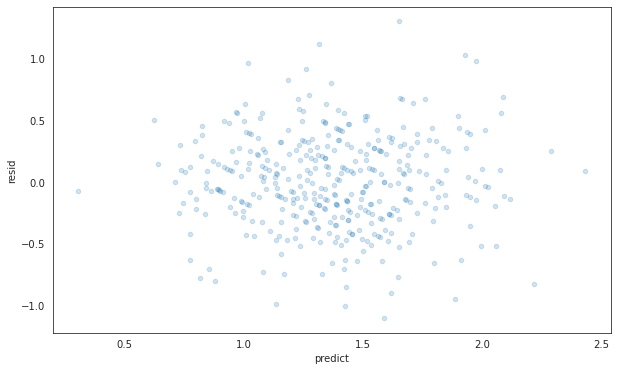

In [25]:
# develop OLS with Sklearn
lr = LinearRegression()
fit = lr.fit(X4,y4) # for later use

# Plot your predicted values on the x-axis, and your residuals on the y-axis

premleague['predict']=fit.predict(X4)
premleague['resid']=premleague['logAnnual_Salary(Mil_GBP)']-premleague.predict
with sns.axes_style('white'):
    plot=premleague.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.2,figsize=(10,6))

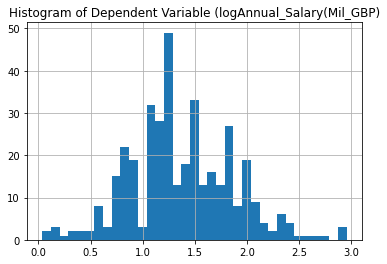

In [26]:
# inspect histogram
premleague['logAnnual_Salary(Mil_GBP)'].hist(bins=35)
plt.title('Histogram of Dependent Variable (logAnnual_Salary(Mil_GBP)');

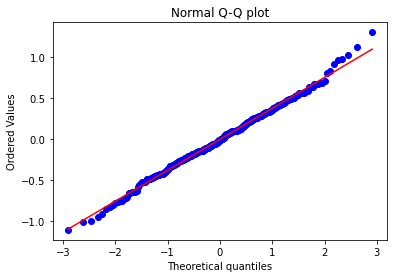

In [27]:
# diagnose/inspect residual normality using qqplot:
stats.probplot(premleague['resid'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

### Error Terms

In [31]:
model = sm.OLS(y4,X4)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                    
==============================================================================================
Dep. Variable:     logAnnual_Salary(Mil_GBP)   R-squared (uncentered):                   0.934
Model:                                   OLS   Adj. R-squared (uncentered):              0.932
Method:                        Least Squares   F-statistic:                              437.2
Date:                       Wed, 15 Jul 2020   Prob (F-statistic):                   1.70e-210
Time:                               00:33:21   Log-Likelihood:                         -168.21
No. Observations:                        383   AIC:                                      360.4
Df Residuals:                            371   BIC:                                      407.8
Df Model:                                 12                                                  
Covariance Type:                   nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Age               0.0379      0.003     12.789      0.000       0.032       0.044
MP               -0.0086      0.005     -1.625      0.105      -0.019       0.002
Starts            0.0182      0.005      3.642      0.000       0.008       0.028
TotPassAtt/90     0.0204      0.007      3.106      0.002       0.007       0.033
Touches/90       -0.0298      0.006     -5.046      0.000      -0.041      -0.018
Rec/90            0.0244      0.004      5.729      0.000       0.016       0.033
logP90Gls         0.3443      0.205      1.683      0.093      -0.058       0.747
logSh/90         -0.0215      0.101     -0.214      0.831      -0.220       0.177
logSoT/90         0.3815      0.149      2.555      0.011       0.088       0.675
logKP/90          0.0820      0.066      1.236      0.217      -0.048       0.212
logProg/90       -0.0778      0.051     -1.519      0.130      -0.179       0.023
logDribPl/90      0.0467      0.068      0.688      0.492      -0.087       0.180
==============================================================================
Omnibus:                        2.049   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.359   Jarque-Bera (JB):                1.996
Skew:                           0.031   Prob(JB):                        0.369
Kurtosis:                       3.348   Cond. No.                     1.06e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

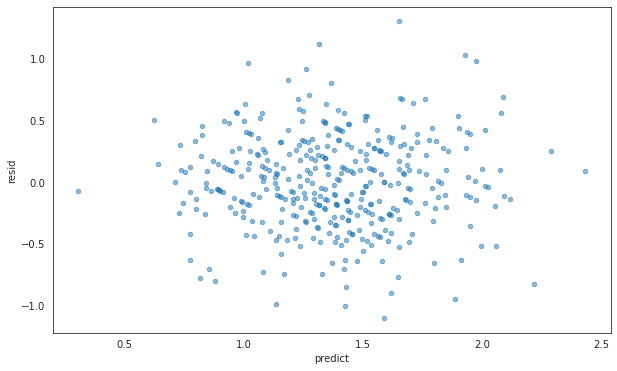

In [32]:
# create residual plot
with sns.axes_style('white'):
    plot = premleague.plot(
        kind='scatter', x='predict', y='resid', alpha=0.5, figsize=(10,6))

## Model Testing

In [33]:
def crossvaltest(X, y):
    '''
    input: X(dataframe) for features, y(series) for target
    output: regression test R^2
    '''
    X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing

    #this helps with the way kf will generate indices below
    X, y = np.array(X), np.array(y)
     
    #run the CV
    kf = KFold(n_splits=5, shuffle=True, random_state = 71)
    cv_lm_r2s, cv_lm_reg_r2s = [], [] #collect the validation results for both models

    for train_ind, val_ind in kf.split(X,y):
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 

        #simple linear regression
        lm = LinearRegression()
        lm_reg = Ridge(alpha=0.17)

        lm.fit(X_train, y_train)
        cv_lm_r2s.append(lm.score(X_val, y_val))
    
        #ridge with feature scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
    
        lm_reg.fit(X_train_scaled, y_train)
        cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))
        
        #test
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_test_scaled = scaler.transform(X_test)

        lm_reg = Ridge(alpha=0.17)
        lm_reg.fit(X_scaled,y)
    
    print(f'Ridge Regression test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')

In [34]:
crossvaltest(X4, y4)

Ridge Regression test R^2: 0.579


# Interpreting Results

In [35]:
coefdict = {}

def coefresults(X, y):
    '''
    input: X(dataframe) of features, y(series) of target
    output: feature coefficient results
    '''
    X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing

    #this helps with the way kf will generate indices below
    X2, y2 = np.array(X), np.array(y)
     
    #run the CV
    kf = KFold(n_splits=5, shuffle=True, random_state = 71)
    cv_lm_r2s, cv_lm_reg_r2s = [], [] #collect the validation results for both models

    for train_ind, val_ind in kf.split(X2,y2):
        X_train, y_train = X2[train_ind], y2[train_ind]
        X_val, y_val = X2[val_ind], y2[val_ind] 

        #simple linear regression
        lm = LinearRegression()
        lm_reg = Ridge(alpha=0.17)

        lm.fit(X_train, y_train)
        cv_lm_r2s.append(lm.score(X_val, y_val))
    
        #ridge with feature scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
    
        lm_reg.fit(X_train_scaled, y_train)
        cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))
        
        #test
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X2)
        X_test_scaled = scaler.transform(X_test)

        lm_reg = Ridge(alpha=0.17)
        lm_reg.fit(X_scaled,y2)
        
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lm_reg.coef_):
        print(feature, ':', f'{coef:.2f}') 
    

    for feature, coef in zip(X.columns, lm_reg.coef_):
        coefdict[feature] = coef
    return coefdict

In [36]:
coefresults(X4, y4)

Feature coefficient results: 

Age : 0.15
MP : -0.10
Starts : 0.22
TotPassAtt/90 : 0.25
Touches/90 : -0.43
Rec/90 : 0.38
logP90Gls : 0.04
logSh/90 : -0.01
logSoT/90 : 0.12
logKP/90 : 0.02
logProg/90 : -0.04
logDribPl/90 : 0.01


{'Age': 0.15495705338048196,
 'MP': -0.0990339403228406,
 'Starts': 0.22243159899368042,
 'TotPassAtt/90': 0.2506396439600576,
 'Touches/90': -0.43418439031570516,
 'Rec/90': 0.38218527474947483,
 'logP90Gls': 0.04143984622877083,
 'logSh/90': -0.008243640205906174,
 'logSoT/90': 0.12073486284558049,
 'logKP/90': 0.01886385263996713,
 'logProg/90': -0.03830439788907951,
 'logDribPl/90': 0.01016872041671547}

In [37]:
import math
coefdict2 = {f'inv{k}':(math.exp(v) - 1) for k, v in coefdict.items()}

In [38]:
coefdict2

{'invAge': 0.1676078152197482,
 'invMP': -0.0942880326546951,
 'invStarts': 0.24911037632173683,
 'invTotPassAtt/90': 0.284846998522003,
 'invTouches/90': -0.3522072022462247,
 'invRec/90': 0.4654835770844854,
 'invlogP90Gls': 0.04231046106062353,
 'invlogSh/90': -0.008209754581546824,
 'invlogSoT/90': 0.1283257116360399,
 'invlogKP/90': 0.019042899171954453,
 'invlogProg/90': -0.03758006229875854,
 'invlogDribPl/90': 0.01022059754640714}